In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import pickle,sys,os
from numpy import *
import ruptures as rpt
from scipy.stats import norm, pearsonr, zscore, rankdata
from sklearn.decomposition import PCA
from sklearn.covariance import EllipticEnvelope
import math
import warnings
warnings.filterwarnings("ignore")
import sklearn
sklearn.__version__

'1.5.1'

In [2]:
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

In [3]:
with open('../../Human_hg38_chrom_ends.pkl','rb') as a:
    ENDS = pickle.load(a)

with open('../../Human_hg38_auto_10kb_windows.pkl','rb') as b:
    W = pickle.load(b)

In [4]:
def get_numpy_arr(infile,columns=None):
    arr_file = load(infile)
    if columns is None:
        arr = arr_file['arr']
    else:
        arr = arr_file['arr'][:,columns]
    for cols in range(arr.shape[1]):
        csum = sum(arr[:,cols])
        arr[:,cols] /= csum
    return arr

def get_full_table(arr,win=10000):
    rows = 0
    full_table = []
    for ch in range(22):
        chrom = 'chr'+str(ch+1)
        bound = ENDS[chrom]
        windows = bound // win
        full_table.append(arr[rows:rows+windows,:])
        rows += windows
    if rows!=arr.shape[0]:
        print('error')
    return full_table

def get_full_table_array_k_chr(full_table,win=10000,k=1):
    ends = []
    if k == 1:
        for ch in range(22):
            if ch == 0:
                arr = full_table[ch]
            else:
                arr = concatenate((arr,full_table[ch]),axis=0)
            ends.append(arr.shape[0])
    else:
        ft = []
        for ch in range(22):
            chrom = 'chr'+str(ch+1)
            bound = ENDS[chrom]
            win2 = win*k
            windows2 = bound // win2
            arr_i = full_table[ch]
            arr_k = zeros((windows2,arr_i.shape[1]))
            for j in range(windows2-1):
                arr_k[j] = arr_i[j*k:(j+1)*k,:].sum(axis=0)
            arr_k[-1] = arr_i[(windows2-1)*k:,:].sum(axis=0)
            if ch==0:
                arr = arr_k
            else:
                arr = concatenate((arr,arr_k),axis=0)
            ends.append(arr.shape[0])
    return arr, ends

def get_arr(infile,columns=None,k=1,print_ends=False):
    df_arr = get_numpy_arr(infile,columns)
    table = get_full_table(df_arr)
    ftk, ends = get_full_table_array_k_chr(table,k=k)
    if print_ends:
        print(ends)
    return ftk #arrs

In [5]:
k = 1
thgs = get_arr('merged_table_no_correction_1000g_10kb.npz',k=k)
thgs.shape

(287487, 3202)

In [6]:
ctrl38s = get_arr('../../merged_table_no_correction_ctrl38_10kb.npz',k=k)
ctdna36s = get_arr('../../merged_table_no_correction_ctdna36luad_10kb.npz',k=k)
brcas = get_arr('../../merged_table_no_correction_brca_10kb.npz',k=k)
crcs = get_arr('../../merged_table_no_correction_crc_10kb.npz',k=k)
ctrl29s = get_arr('../../merged_table_no_correction_ctrl29_10kb.npz',k=k)
ega8460 = get_arr('../../merged_table_no_correction_EGA8460_10kb.npz',k=k)
ega5343_ctrl = get_arr('../../merged_table_no_correction_EGA5343_ctrl_10kb.npz',k=k)

In [7]:
ega5343_prostate = get_arr('../../merged_table_no_correction_EGA5343_prostate_10kb.npz',k=k)

In [8]:
arr_file = load('../../merged_table_no_correction_EGA7080_10kb.npz')
samples = arr_file['samples']

ctrl = [i for i in range(len(samples)) if samples[i].startswith('Ctrl')]
ctdna = [i for i in range(len(samples)) if i not in ctrl] # and samples[i].endswith('_1')
ega7080_ctrl = get_arr('../../merged_table_no_correction_EGA7080_10kb.npz',columns=ctrl,k=k)
ega7080_ctdna = get_arr('../../merged_table_no_correction_EGA7080_10kb.npz',columns=ctdna,k=k,print_ends=True)

[24895, 49114, 68943, 87964, 106117, 123197, 139131, 153644, 167483, 180862, 194370, 207697, 219133, 229837, 240036, 249069, 257394, 265431, 271292, 277736, 282406, 287487]


In [9]:
ends = [24895, 49114, 68943, 87964, 106117, 123197,139131, 153644, 167483, 180862, 
        194370, 207697, 219133, 229837, 240036, 249069, 257394, 265431, 271292, 277736, 282406, 287487]
feats = [i for i in range(thgs.shape[0]) if sum(thgs[i,:])>0]
print(ends[-1]-len(feats))
#zf = [i for i in range(thgs.shape[0]) if i not in feats]
#print(len(zf))
chr_splits = [0]
j = 0
for e in ends:
    for i in range(j,len(feats)):
        if feats[i] > e:
            chr_splits.append(i)
            j = i
            break
chr_splits.append(len(feats))
print(chr_splits)

51248
[0, 21838, 43007, 61151, 77732, 93356, 108799, 122508, 135682, 146854, 158478, 170121, 181337, 190291, 197701, 205137, 211316, 216730, 222093, 226049, 231029, 233445, 236239]


In [10]:
def get_rank(arr):
    ranked_arr = []
    for i in range(arr.shape[1]):
        ranked = rankdata(arr[:,i],'min')
        ranked_arr.append(ranked)
    return array(ranked_arr).T

In [11]:
rctrl38s = get_rank(ctrl38s[feats,:])
rctdna36s = get_rank(ctdna36s[feats,:])
rbrcas = get_rank(brcas[feats,:])
rcrcs = get_rank(crcs[feats,:])
rctrl29s = get_rank(ctrl29s[feats,:])
rega5343_ctrl = get_rank(ega5343_ctrl[feats,:])
rega7080_ctrl = get_rank(ega7080_ctrl[feats,:])
rega8460 = get_rank(ega8460[feats,:])
rega7080_ctdna = get_rank(ega7080_ctdna[feats,:])
rthgs = get_rank(thgs[feats,:])

In [12]:
rega5343_prostate = get_rank(ega5343_prostate[feats,:])

In [13]:
rctrls = hstack((rega5343_ctrl,rega7080_ctrl,rctrl38s,rctrl29s))

In [14]:
rctdnas = hstack((rega7080_ctdna,rctdna36s,rbrcas,rcrcs,rega8460))

In [15]:
# segmentation
def get_breakpoints(arr=rthgs,splits=chr_splits):
    bkps = {}
    breaks = [0]
    offset = 0
    for ch in range(22):
        ctrl_signals = mean(arr[splits[ch]:splits[ch+1],:],axis=1)
        sigma = std(ctrl_signals)
        n = len(ctrl_signals)
        if n < 100:
            offset+=n
            continue
        algo = rpt.Binseg(model="l1",min_size=100).fit(ctrl_signals) # min size is 1Mbp # "l1", "rbf", "linear", "normal", "ar",...
        my_bkps = algo.predict(pen=log(n)*sigma)
        bkps['chr'+str(ch+1)] = [offset]+[x+offset for x in my_bkps]
        breaks += [x+offset for x in my_bkps]
        offset+= n
    return bkps, breaks
bkps, breaks = get_breakpoints()

In [16]:
def get_segment_mean(arr,breaks=breaks):
    n = len(breaks)-1
    arr_seg = []
    for i in range(n):
        arr_seg.append(mean(arr[breaks[i]:breaks[i+1],:],axis=0))
    return array(arr_seg)

def get_rank_hist(arr, nbins=8):
    hist = []
    for s in range(arr.shape[1]):
        h,_ = histogram(arr[:,s], bins=linspace(0,240000,nbins+1))
        hist.append(h/sum(h))
    return array(hist).T   # 8 x n

In [17]:
sctrl38s = get_segment_mean(rctrl38s)
sctrl29s = get_segment_mean(rctrl29s) 
sega7080_ctrl = get_segment_mean(rega7080_ctrl)
sega5343_ctrl = get_segment_mean(rega5343_ctrl)
print(median(std(sctrl38s,axis=1)),median(std(sctrl29s,axis=1)),median(std(sega7080_ctrl,axis=1)),median(std(sega5343_ctrl,axis=1)))

14766.613891687324 9091.224919564898 8910.747007094713 5086.423075596531


In [18]:
nsegments = []
for j in range(1,23):
    chrom = 'chr'+str(j)
    nsegments.append((chrom,len(bkps[chrom])-1))
print(nsegments)

[('chr1', 98), ('chr2', 100), ('chr3', 78), ('chr4', 81), ('chr5', 75), ('chr6', 71), ('chr7', 67), ('chr8', 67), ('chr9', 48), ('chr10', 56), ('chr11', 56), ('chr12', 41), ('chr13', 32), ('chr14', 35), ('chr15', 36), ('chr16', 28), ('chr17', 20), ('chr18', 30), ('chr19', 21), ('chr20', 21), ('chr21', 12), ('chr22', 17)]


In [19]:
def EllipticEnv_predict(arr,ctrl,error=0.05,support_fraction=None,return_clf=True): # feats x n  
    estimator = EllipticEnvelope(random_state=12345,contamination=error,support_fraction=support_fraction).fit(ctrl.T) 
    if return_clf:
        return estimator.predict(arr.T), estimator
    else:
        return estimator.predict(arr.T)

In [20]:
def Calculate_alpha(rctrl,spe=0.9,error=0.05,support_fraction=0.9):
    arr_labels = ensemble_clf(rctrl,rctrl,alpha=None,support_fraction=support_fraction)
    sorted_vals = sorted(arr_labels)[::-1]; alphas = [1-x for x in sorted_vals]; #print(mean(alphas[:-1]),std(alphas[:-1]))
    n = math.ceil(len(arr_labels)*spe); 
    alpha = round(1-sorted_vals[n-1],2); print('alpha:',alpha,'specificity:',n/len(arr_labels))
    return alpha

# 8 dimensions sum to 1; 7 dims encodes all info
def ensemble_clf(rarr,rctrl,alpha,dims=[1,2,3,4,5,6,7],incl=['chr1','chr2','chr3','chr4','chr5','chr6','chr7','chr8','chr9','chr10','chr11',
                'chr12','chr13','chr14','chr15','chr16','chr17','chr18','chr20'], error=0.05, support_fraction = 0.7, return_raw=True):
    arr_labels = zeros(rarr.shape[1]); count = 0
    for chrom in incl:
        nseg = len(bkps[chrom])-1; #print(chrom,nseg)
        arr = get_rank_hist(get_segment_mean(rarr,breaks=bkps[chrom]))[dims,:]
        ctrl = get_rank_hist(get_segment_mean(rctrl,breaks=bkps[chrom]))[dims,:]
        labels = array([max([x,0]) for x in EllipticEnv_predict(arr,ctrl,error=error,support_fraction=support_fraction,return_clf=False)]) # -1 for outlier, +1 inlier
        labels *= nseg
        arr_labels += labels
        count += nseg
    arr_labels/=count
    if return_raw:
        return arr_labels
    #print("total number of segments:",count)
    preds = []
    for x in arr_labels:
        if 1-x > alpha:
            preds.append(1) # 1 outlier
        else:
            preds.append(0) # 0 inlier
    return preds

def evaluate_performance(pred,truth):
    tn, fp, fn, tp = confusion_matrix(truth, pred, labels=[0, 1]).ravel()
    specificity = None; sensitivity = None
    if tn+fp > 0:
        specificity = tn / (tn+fp) #print('specificity:',specificity)
    if tp+fn > 0:
        sensitivity = tp/(tp+fn) #print('sensitivity:',sensitivity)
    return sensitivity, specificity

In [21]:
# matched task, use at least 90% control samples for covariance estimate, i.e., support_fraction=0.9
alpha = Calculate_alpha(rega7080_ctrl,spe=0.9,support_fraction=0.9)
predY = ensemble_clf(rega7080_ctdna,rega7080_ctrl,alpha=alpha,support_fraction=0.9,return_raw=False)
sens,spec = evaluate_performance(predY,[1]*241)
print('sensitivity:',sens)

alpha: 0.15 specificity: 0.9090909090909091
sensitivity: 0.8340248962655602


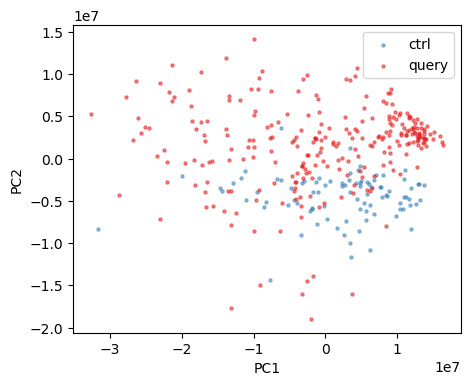

In [22]:
fig, axs = plt.subplots(ncols=1, figsize=(5, 4))
pca = PCA(n_components=2)
X = hstack((rctrl38s,rctrl29s,rega5343_ctrl,rega7080_ctdna,rega7080_ctrl)).T
X_r = pca.fit_transform(X)
y = array([0]*91+[1]*263)
target_names = ['ctrl','query']
colors = sns.color_palette("Set1", 2)[::-1]
for color, i, target_name in zip(colors, [0, 1], target_names):
    axs.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.5, s=5, label=target_name)
axs.set_xlabel('PC1');axs.set_ylabel('PC2');axs.legend()

In [23]:
# unmatched task, multiple control sets are used, making differences within control larger, use 70% samples for covaraince estimate
# PCA plot shows substantial overlap between ctrl set and the query set
alpha = Calculate_alpha(hstack((rctrl38s,rctrl29s,rega5343_ctrl)),spe=0.9,support_fraction=0.7)
predY = ensemble_clf(hstack((rega7080_ctdna,rega7080_ctrl)),hstack((rctrl38s,rctrl29s,rega5343_ctrl)),alpha=alpha,support_fraction=0.7,return_raw=False)
sens,spec = evaluate_performance(predY,[1]*241+[0]*22)
print('sensitivity:',sens)
print('specificity:',spec)

alpha: 0.19 specificity: 0.9010989010989011
sensitivity: 0.5601659751037344
specificity: 0.9090909090909091


In [24]:
# matched task
alpha = Calculate_alpha(rctrl38s,spe=0.9,support_fraction=0.9)
predY = ensemble_clf(rctdna36s,rctrl38s,alpha=alpha,support_fraction=0.9,return_raw=False)
sens,spec = evaluate_performance(predY,[1]*36)
print('sensitivity:',sens)

alpha: 0.09 specificity: 0.9210526315789473
sensitivity: 0.2777777777777778


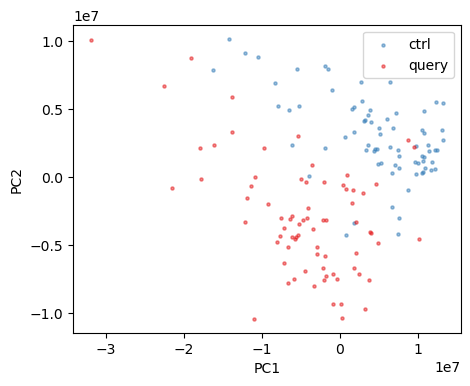

In [25]:
fig, axs = plt.subplots(ncols=1, figsize=(5, 4))
pca = PCA(n_components=2)
X = hstack((rega7080_ctrl,rctrl29s,rega5343_ctrl,rctdna36s,rctrl38s)).T
X_r = pca.fit_transform(X)
y = array([0]*75+[1]*74)
target_names = ['ctrl','query']
colors = sns.color_palette("Set1", 2)[::-1]
for color, i, target_name in zip(colors, [0, 1], target_names):
    axs.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.5, s=5, label=target_name)
axs.set_xlabel('PC1');axs.set_ylabel('PC2');axs.legend()

In [26]:
# unmatched task
# PCA plot shows fewer overlap between ctrl set and the query set, use a larger specificity constraint (0.95)
alpha = Calculate_alpha(hstack((rega7080_ctrl,rctrl29s,rega5343_ctrl)),spe=0.95,support_fraction=0.7)
predY = ensemble_clf(hstack((rctdna36s,rctrl38s)),hstack((rega7080_ctrl,rctrl29s,rega5343_ctrl)),alpha=alpha,support_fraction=0.7,return_raw=False)
sens,spec = evaluate_performance(predY,[1]*36+[0]*38)
print('sensitivity:',sens)
print('specificity:',spec)

alpha: 0.43 specificity: 0.96
sensitivity: 0.16666666666666666
specificity: 0.868421052631579


In [27]:
# matched task
alpha = Calculate_alpha(rega5343_ctrl,spe=0.9,support_fraction=0.9)
#alpha = 0.17
predY = ensemble_clf(rega5343_prostate,rega5343_ctrl,alpha=alpha,support_fraction=0.9,return_raw=False)
sens,spec = evaluate_performance(predY,[1]*4)
print('sensitivity:',sens)

alpha: 0.2 specificity: 0.9166666666666666
sensitivity: 1.0


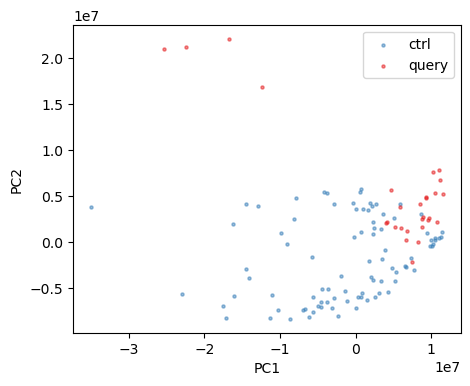

In [28]:
fig, axs = plt.subplots(ncols=1, figsize=(5, 4))
pca = PCA(n_components=2)
X = hstack((rega7080_ctrl,rctrl29s,rctrl38s,rega5343_prostate,rega5343_ctrl)).T
X_r = pca.fit_transform(X)
y = array([0]*89+[1]*28)
target_names = ['ctrl','query']
colors = sns.color_palette("Set1", 2)[::-1]
for color, i, target_name in zip(colors, [0, 1], target_names):
    axs.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.5, s=5, label=target_name)
axs.set_xlabel('PC1');axs.set_ylabel('PC2');axs.legend()

In [29]:
# unmatched task
# PCA plot shows few overlap between ctrl set and the query set, use a large specificity constraint (0.95)
alpha = Calculate_alpha(hstack((rega7080_ctrl,rctrl29s,rctrl38s)),spe=0.95,support_fraction=0.7)
predY = ensemble_clf(hstack((rega5343_prostate,rega5343_ctrl)),hstack((rega7080_ctrl,rctrl29s,rctrl38s)),alpha=alpha,support_fraction=0.7,return_raw=False)
sens,spec = evaluate_performance(predY,[1]*4+[0]*24)
print('sensitivity:',sens)
print('specificity:',spec)

alpha: 0.27 specificity: 0.9550561797752809
sensitivity: 1.0
specificity: 1.0


#### When PCA shows no overlap, use a very strict specificity contraint (>0.95) on training and interpret results carefully

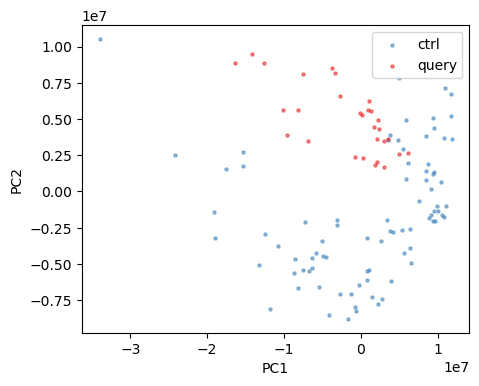

In [30]:
fig, axs = plt.subplots(ncols=1, figsize=(5, 4))
pca = PCA(n_components=2)
X = hstack((rega7080_ctrl,rctrl38s,rega5343_ctrl,rctrl29s)).T
X_r = pca.fit_transform(X)
y = array([0]*84+[1]*29)
target_names = ['ctrl','query']
colors = sns.color_palette("Set1", 2)[::-1]
for color, i, target_name in zip(colors, [0, 1], target_names):
    axs.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.5, s=5, label=target_name)
axs.set_xlabel('PC1');axs.set_ylabel('PC2');axs.legend()

In [31]:
# unmatched task
# PCA plot shows very few overlap between ctrl set and the query set, use a very large specificity constraint (0.97)
alpha = Calculate_alpha(hstack((rega7080_ctrl,rctrl38s,rega5343_ctrl)),spe=0.97,support_fraction=0.7)
predY = ensemble_clf(rctrl29s,hstack((rega7080_ctrl,rega5343_ctrl,rctrl38s)),alpha=alpha,support_fraction=0.7,return_raw=False)
sens,spec = evaluate_performance(predY,[0]*29)
#print('sensitivity:',sens)
print('specificity:',spec)

alpha: 0.7 specificity: 0.9761904761904762
specificity: 0.896551724137931


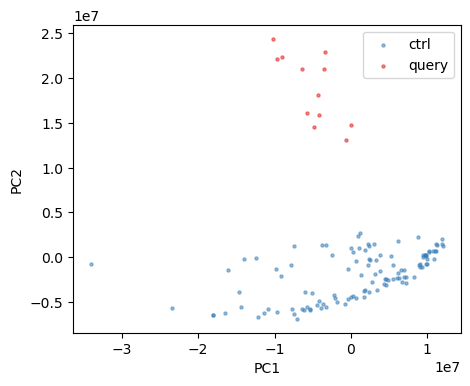

In [32]:
fig, axs = plt.subplots(ncols=1, figsize=(5, 4))
pca = PCA(n_components=2)
X = hstack((rega7080_ctrl,rctrl38s,rega5343_ctrl,rctrl29s,rcrcs)).T
X_r = pca.fit_transform(X)
y = array([0]*113+[1]*12)
target_names = ['ctrl','query']
colors = sns.color_palette("Set1", 2)[::-1]
for color, i, target_name in zip(colors, [0, 1], target_names):
    axs.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.5, s=5, label=target_name)
axs.set_xlabel('PC1');axs.set_ylabel('PC2');axs.legend()

In [33]:
# unmatched task
# PCA plot shows no overlap between ctrl set and the query set, use a very large specificity constraint (0.97)
alpha = Calculate_alpha(hstack((rctrl29s,rega7080_ctrl,rega5343_ctrl,rctrl38s)),spe=0.97,support_fraction=0.7)
predY = ensemble_clf(rcrcs,hstack((rctrl29s,rega7080_ctrl,rega5343_ctrl,rctrl38s)),alpha=alpha,support_fraction=0.7,return_raw=False)
sens,spec = evaluate_performance(predY,[1]*rcrcs.shape[1])
print('sensitivity:',sens)

alpha: 0.42 specificity: 0.9734513274336283
sensitivity: 1.0


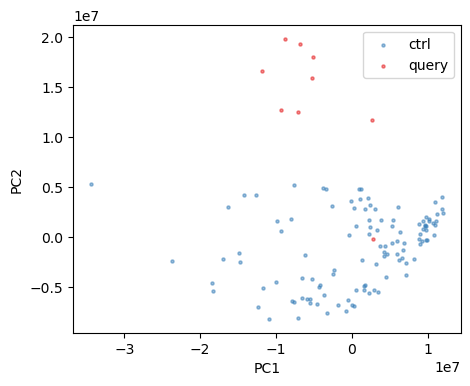

In [34]:
fig, axs = plt.subplots(ncols=1, figsize=(5, 4))
pca = PCA(n_components=2)
X = hstack((rega7080_ctrl,rctrl38s,rega5343_ctrl,rctrl29s,rbrcas)).T
X_r = pca.fit_transform(X)
y = array([0]*113+[1]*9)
target_names = ['ctrl','query']
colors = sns.color_palette("Set1", 2)[::-1]
for color, i, target_name in zip(colors, [0, 1], target_names):
    axs.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.5, s=5, label=target_name)
axs.set_xlabel('PC1');axs.set_ylabel('PC2');axs.legend()

In [35]:
# unmatched task
# PCA plot shows no overlap between ctrl set and the query set, use a very large specificity constraint (0.97)
alpha = Calculate_alpha(hstack((rctrl29s,rega7080_ctrl,rega5343_ctrl,rctrl38s)),spe=0.97,support_fraction=0.7)
predY = ensemble_clf(rbrcas,hstack((rctrl29s,rega7080_ctrl,rega5343_ctrl,rctrl38s)),alpha=alpha,support_fraction=0.7,return_raw=False)
sens,spec = evaluate_performance(predY,[1]*rbrcas.shape[1])
print('sensitivity:',sens)

alpha: 0.42 specificity: 0.9734513274336283
sensitivity: 1.0


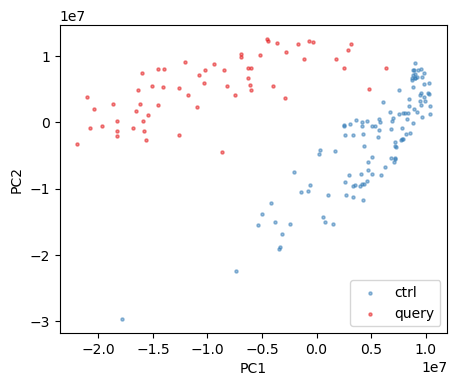

In [36]:
fig, axs = plt.subplots(ncols=1, figsize=(5, 4))
pca = PCA(n_components=2)
X = hstack((rega7080_ctrl,rctrl38s,rega5343_ctrl,rctrl29s,rega8460)).T
X_r = pca.fit_transform(X)
y = array([0]*113+[1]*60)
target_names = ['ctrl','query']
colors = sns.color_palette("Set1", 2)[::-1]
for color, i, target_name in zip(colors, [0, 1], target_names):
    axs.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.5, s=5, label=target_name)
axs.set_xlabel('PC1');axs.set_ylabel('PC2');axs.legend()

In [37]:
# unmatched task
# PCA plot shows no overlap between ctrl set and the query set, use a very large specificity constraint (0.97)
alpha = Calculate_alpha(hstack((rctrl29s,rega7080_ctrl,rega5343_ctrl,rctrl38s)),spe=0.97,support_fraction=0.7)
predY = ensemble_clf(rega8460,hstack((rctrl29s,rega7080_ctrl,rega5343_ctrl,rctrl38s)),alpha=alpha,support_fraction=0.7,return_raw=False)
sens,spec = evaluate_performance(predY,[1]*rega8460.shape[1])
print('sensitivity:',sens)

alpha: 0.42 specificity: 0.9734513274336283
sensitivity: 0.95
